In [1]:
%matplotlib inline
import time
import random
from random import shuffle
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import pickle
from mpl_toolkits.axes_grid1 import ImageGrid
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from PIL import Image
import itertools
import logging
import os

import torch
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision
from torchvision import transforms, datasets, models
from torchvision.datasets import CIFAR10

from scipy.stats import entropy, ks_2samp
from scipy.special import kl_div
from sklearn import metrics
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import label_binarize

# from torch.utils.tensorboard import SummaryWriter
# %load_ext tensorboard

import traceback
import copy

In [2]:
logname = 'logs/decentralized_distil'
logging.basicConfig(filename=logname,
                            filemode='a',
                            format='%(asctime)s,%(msecs)d %(name)s %(levelname)s %(message)s',
                            datefmt='%H:%M:%S',
                            level=logging.DEBUG)

logging.info("Running Decentralized Learning test")

logger = logging.getLogger('Decentralized_log')

In [3]:
np.random.seed(0)
torch.manual_seed(3)

In [4]:
class CustomDataSet(Dataset):
    def __init__(self, main_dir, x, y, transform):
        self.main_dir = main_dir
        self.transform = transform
        self.y = y
        self.all_imgs = x
#         self.total_imgs = natsort.natsorted(all_imgs)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, self.all_imgs[idx])
        image = Image.open(img_loc).convert("RGB")
        tensor_image = self.transform(image)
        return tensor_image,self.y[idx]

In [5]:
# Standard transformations for improving CIFAR10. 

# Transformations A
print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.RandomCrop((218,178), padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Transformations B
RC   = transforms.RandomCrop((218,178), padding=4)
RHF  = transforms.RandomHorizontalFlip()
RVF  = transforms.RandomVerticalFlip()
NRM  = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
TT   = transforms.ToTensor()
TPIL = transforms.ToPILImage()

# Transforms object for trainset with augmentation
transform_with_aug = transforms.Compose([RC, RHF, TT, NRM])
# Transforms object for testset with NO augmentation
transform_no_aug   = transforms.Compose([TT, NRM])

# Downloading/Louding CELEBA data
trainset = torchvision.datasets.CelebA(root='../../../data/celebA', split = 'train',
                                        download=True, transform=transform_with_aug)

testset = torchvision.datasets.CelebA(root='../../../data/celebA', split='test',
                                       download=True, transform=transform_no_aug)

classDict = {'not_smiling':0, 'smiling':1}

# Separating trainset/testset data/label
x_train  = trainset
x_test   = testset
y_train  = trainset.attr[:,31]
y_test   = testset.attr[:,31]

# Define a function to separate CIFAR classes by class index

def get_class_i(x, y, i):
    """
    x: trainset.train_data or testset.test_data
    y: trainset.train_labels or testset.test_labels
    i: class label, a number between 0 to 9
    return: x_i
    """
    # Convert to a numpy array
    y = np.array(y)
    # Locate position of labels that equal to i
    pos_i = np.argwhere(y == i)
    # Convert the result into a 1-D list
    pos_i = list(pos_i[:,0])
    # Collect all data that match the desired label
    x_i = [x[j] for j in pos_i]
    
    return x_i

class DatasetMaker(Dataset):
    def __init__(self, datasets, transformFunc = transform_no_aug):
        """
        datasets: a list of get_class_i outputs, i.e. a list of list of images for selected classes
        """
        self.datasets = datasets
        self.lengths  = [len(d) for d in self.datasets]
        self.transformFunc = transformFunc
    def __getitem__(self, i):
        class_label, index_wrt_class = self.index_of_which_bin(self.lengths, i)
        img = self.datasets[class_label][index_wrt_class]
        img = self.transformFunc(img)
        return img, class_label

    def __len__(self):
        return sum(self.lengths)
    
    def index_of_which_bin(self, bin_sizes, absolute_index, verbose=False):
        """
        Given the absolute index, returns which bin it falls in and which element of that bin it corresponds to.
        """
        # Which class/bin does i fall into?
        accum = np.add.accumulate(bin_sizes)
        if verbose:
            print("accum =", accum)
        bin_index  = len(np.argwhere(accum <= absolute_index))
        if verbose:
            print("class_label =", bin_index)
        # Which element of the fallent class/bin does i correspond to?
        index_wrt_class = absolute_index - np.insert(accum, 0, 0)[bin_index]
        if verbose:
            print("index_wrt_class =", index_wrt_class)

        return bin_index, index_wrt_class

==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified


In [6]:
# If we are saving a fraction of random data to be used in training

frac1 = int(len(x_test) * 0.316666666667)
frac2 = int(len(x_test) * 0.633333333333)

x_train1 = np.array(x_train.filename[0:frac1])
y_train1 = np.array(y_train[0:frac1])
x_train2 = np.array(x_train.filename[frac1:frac2])
y_train2 = np.array(y_train[frac1:frac2])
x_train3 = np.array(x_train.filename[frac2:])
y_train3 = np.array(y_train[frac2:])

x_test = np.array(x_test.filename)
y_test = np.array(y_test)

In [7]:
trainset1 = CustomDataSet('../../../data/celebA/celeba/img_align_celeba',x=x_train1,y=y_train1, transform=transform_with_aug)
trainset2 = CustomDataSet('../../../data/celebA/celeba/img_align_celeba',x=x_train2,y=y_train2, transform=transform_with_aug)
trainset3 = CustomDataSet('../../../data/celebA/celeba/img_align_celeba',x=x_train3,y=y_train3, transform=transform_with_aug)
testset = CustomDataSet('../../../data/celebA/celeba/img_align_celeba',x=x_test,y=y_test, transform=transform_no_aug)

In [8]:
kwargs = {'num_workers': 5, 'pin_memory': False}
trainsetLoader1 = DataLoader(trainset1 , batch_size=28, shuffle=True, **kwargs)
trainsetLoader2 = DataLoader(trainset2 , batch_size=28, shuffle=True, **kwargs)
trainsetLoader3 = DataLoader(trainset3 , batch_size=28, shuffle=True, **kwargs)
testsetLoader = DataLoader(testset , batch_size=28, shuffle=True, **kwargs)

In [9]:
def imshow(img):
    img = img / 2 + 0.3    # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

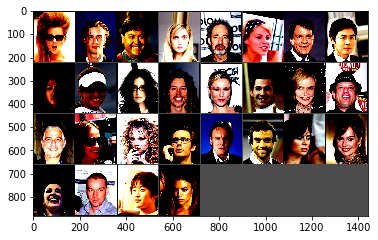

In [10]:
img, label = next(iter(trainsetLoader1))
imshow(torchvision.utils.make_grid(img))

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(device)
print(device)

# device2 = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

cuda:0


# Decentralized model using reserved data

## Train a knowledge transfer model

In [12]:
def kaiming_init(m):
    if isinstance(m, (torch.nn.Linear)):
        torch.nn.init.sparse_(m.weight, sparsity=0.33)
        if m.bias is not None:
            m.bias.data.fill_(0)
    elif isinstance(m, (torch.nn.Conv2d)):
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0)
    elif isinstance(m, (torch.nn.BatchNorm1d, torch.nn.BatchNorm2d)):
        m.weight.data.fill_(1)
        if m.bias is not None:
            m.bias.data.fill_(0)

class Decenter(torch.nn.Module):

    def __init__(self, shape):
        super(Decenter, self).__init__()
        if len(shape) == 1:
            shape = shape[0]
            self.dim = 0
        elif len(shape) == 2:
            shape = shape[1]
            self.dim = 1
        self.translation = torch.nn.Sequential(
#             torch.nn.Tanh(),
            torch.nn.Linear(shape*3, shape)
        )

#         self.weight_init()

    def weight_init(self):
        for block in self._modules:
            for m in self._modules[block]:
                kaiming_init(m)

    def forward(self, source1, source2, target):
        x = torch.cat((source1, source2, target), self.dim)
#         x = torch.cat((torch.flatten(source), torch.flatten(target)), 0)
#         x = torch.add(torch.flatten(source).to("cpu"), torch.flatten(target).to("cpu"))
        res = self.translation(x)
#         res = res.reshape(target.shape)
        return res
    
    
class Interpolate(torch.nn.Module):
    def __init__(self, size, mode):
        super(Interpolate, self).__init__()
        self.interp = torch.nn.functional.interpolate
        self.size = size
        self.mode = mode
        
    def forward(self, x):
        x = self.interp(x, size=self.size, mode=self.mode, align_corners=False)
        return x
    
class Reshape(torch.nn.Module):
    def __init__(self, *args):
        super(Reshape, self).__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)
    
class Decenter_pooled(torch.nn.Module):

    def __init__(self, shape):
        super(Decenter_pooled, self).__init__()
        self.shape = shape
        self.translation = torch.nn.Sequential(
#             torch.nn.BatchNorm2d(channels_out),
#             torch.nn.AdaptiveAvgPool2d(1),
            Interpolate(size=1, mode='bilinear'),
            Reshape(shape[0], shape[1]*2),
            torch.nn.Linear(shape[1]*2, shape[1]*shape[-1]*shape[-1]),
#             Reshape(shape[0], shape[1] ,1 ,1),
        )

#         self.weight_init()

    def weight_init(self):
        for block in self._modules:
            for m in self._modules[block]:
                kaiming_init(m)

    def forward(self, source, target):
        x = torch.cat((source, target), 1)
        res = self.translation(x)
        res = res.view(self.shape[0], self.shape[1], self.shape[2], self.shape[3])
        return res
    
    
class Decenter_conv(torch.nn.Module):

    def __init__(self, shape):
        super(Decenter_conv, self).__init__()
        self.shape = shape
        channels_in = shape[1]*3
        channels_out = shape[1]
        self.translation = torch.nn.Sequential(
            torch.nn.BatchNorm2d(channels_in),
            torch.nn.Conv2d(channels_in, channels_out, 3, stride=1, padding=1)
#             torch.nn.ConvTranspose2d(channels_in, channels_out, 3, stride=1, padding=1)
#             torch.nn.Linear(shape[0]*2, shape[0]*4),
#             torch.nn.Dropout(p=0.5),
#             torch.nn.Linear(shape[0]*2, shape[0]),
#             torch.nn.AdaptiveAvgPool2d((shape[-2],shape[-1])),
#             torch.nn.Conv2d(channels_out, channels_out, 3, stride=1, padding=1)

        )
        self.translation2 = torch.nn.Sequential(
            torch.nn.AdaptiveMaxPool2d((shape[-2],shape[-1])),
        )

#         self.weight_init()

    def weight_init(self):
        for block in self._modules:
            for m in self._modules[block]:
                kaiming_init(m)

    def forward(self, source1, source2, target):
        x = torch.cat((source1, source2, target), 1)
#         x = x.reshape(-1, x.shape[0])
#         x = torch.cat((torch.flatten(source), torch.flatten(target)), 0)
#         x = torch.add(torch.flatten(source).to("cpu"), torch.flatten(target).to("cpu"))
        res = self.translation(x)
#         res = res.reshape(self.shape)
        return res

In [13]:
grad_dict: dict = {}
def fc_hook(layer_name, grad_input, grad_output): 
    if layer_name not in grad_dict:
        grad_dict[layer_name] = {}
        grad_dict[layer_name]["grad_input"] = []
        grad_dict[layer_name]["grad_output"] = []
        grad_dict[layer_name]["labels"] = []
        
#     print(grad_input)
#     print(grad_output)
    grad_dict[layer_name]["grad_input"].append(grad_input[0].cpu().numpy())
    grad_dict[layer_name]["grad_output"].append(grad_output[0].cpu().numpy())
    
# def reserve_step(source, target):
    

matlst = []
fclst = []

options = {0: ['trainA', 'validA','reservedAB'], 
           1: ['trainB','validB','reservedBA'],
           2: ['trainC','validC','reservedCA','validC']}

def train_model(dataloders, model, criterion, optimizer, scheduler, num_epochs=25):
#     writer = SummaryWriter('runs/') 

    since = time.time()
    use_gpu = torch.cuda.is_available()
    best_model_wts = 0.0
    best_acc = 0.0
    dataset_sizes = {'trainA': len(dataloders['trainA'].sampler),
                     'trainB': len(dataloders['trainB'].sampler),
                     'trainC': len(dataloders['trainC'].sampler),
                     'reservedA': len(dataloders['reservedA'].sampler),
                     'reservedB': len(dataloders['reservedB'].sampler),
                     'reservedCA': len(dataloders['reservedCA'].sampler),
                     'reservedAB': len(dataloders['reservedAB'].sampler),
                     'reservedBA': len(dataloders['reservedBA'].sampler),
                     'validA': len(dataloders['validA'].sampler),
                     'validB': len(dataloders['validB'].sampler),
                     'validC': len(dataloders['validC'].sampler)}

    i = 0
    ivc = 0
    for epoch in range(num_epochs):
        for phase in ['trainA', 'validA','trainB','validB','trainC','validC','reservedCA','validC']:
#         choice = np.random.choice(range(3), replace=False)
#         for phase in options[choice]:
            if phase not in ['validA','validB','validC']:
                model[phase].train(True)
            else:
                model['trainA'].train(False)
                model['trainB'].train(False)
                model['trainC'].train(False)
            
            
            running_loss = 0.0
            running_corrects = 0                    
                    
            for inputs, labels in dataloders[phase]:
                if use_gpu:
                    inputs, labels = Variable(inputs.to(device)), Variable(labels.to(device))
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                optimizer[phase].zero_grad()

                outputs = model[phase](inputs)
                _, preds = torch.max(outputs.data, 1)
                
                if phase in ['reservedCA','reservedAB','reservedBA']:
                    loss_a = criterion['trainC'](outputs, labels)
                    if phase == 'reservedCA':
                        outputs2 = model['trainA'](inputs)
                        outputs3 = model['trainB'](inputs)
                    elif phase == 'reservedAB':
                        outputs2 = model['trainC'](inputs)
                        outputs3 = model['trainB'](inputs)
                    elif phase == 'reservedBA':
                        outputs2 = model['trainC'](inputs)
                        outputs3 = model['trainA'](inputs)
    
                    sm = torch.nn.Softmax(dim=1)
                    outputs = sm(outputs)
                    outputs2 = sm(outputs2)
                    outputs3 = sm(outputs3)
                    loss_b = criterion[phase](outputs, outputs2)
                    loss_c = criterion[phase](outputs, outputs3)
                    loss = (loss_a + (loss_b + loss_c)/2)/2
                else:
                    loss = criterion[phase](outputs, labels)

                if phase not in ['validA','validB','validC']:
                    loss.backward()
                    optimizer[phase].step()
                                    
                running_loss += loss.item()
                running_corrects += torch.sum(preds == labels.data)

            if phase in ['validA','validB','validC']:
                scheduler[phase].step(running_loss)
                
            if phase not in ['validA','validB','validC']:
                train_epoch_loss = running_loss / dataset_sizes[phase]
                train_epoch_acc = running_corrects.double() / dataset_sizes[phase]
            else:
                valid_epoch_loss = running_loss / dataset_sizes[phase]
                valid_epoch_acc = running_corrects.double() / dataset_sizes[phase]
                print('Epoch [{}/{}] phase: {} train loss: {:.4f} acc: {:.4f} ' 
                      'valid loss: {:.4f} acc: {:.4f}'.format(
                        epoch, num_epochs - 1,
                        phase,
                        train_epoch_loss, train_epoch_acc, 
                        valid_epoch_loss, valid_epoch_acc))
                print() 
                logger.info('Epoch [{}/{}] phase: {} train loss: {:.4f} acc: {:.4f} ' 
                      'valid loss: {:.4f} acc: {:.4f}'.format(
                        epoch, num_epochs - 1,
                        phase,
                        train_epoch_loss, train_epoch_acc, 
                        valid_epoch_loss, valid_epoch_acc))
                
                ## Writing to tensorboard
#                 if phase == 'validC':
#                     ivc += 1
#                     if ivc == 2:
#                         writer.add_histogram('distribution centers/our_full_mesh', outputs, i)

#                         writer.add_scalar('train/loss_our_full_mesh', train_epoch_loss, epoch)
#                         writer.add_scalar('train/accuracy_our_full_mesh', train_epoch_acc, epoch)

#                         writer.add_scalar('valid/loss_our_full_mesh', valid_epoch_loss, epoch)
#                         writer.add_scalar('valid/accuracy_our_full_mesh', valid_epoch_acc, epoch)
#                         ivc = 0

                
            if phase in ['validA','validB','validC'] and valid_epoch_acc > best_acc:
                best_acc = valid_epoch_acc
                best_model_wts = model[phase].state_dict()

            i+=1
    print('Best val Acc: {:4f}'.format(best_acc))
    logger.info('Best val Acc: {:4f}'.format(best_acc))

#     writer.close()
#     model.load_state_dict(best_model_wts)
    return model

In [14]:
resnetA = models.resnet50(pretrained=True)
resnetB = models.resnet50(pretrained=True)
resnetC = models.resnet50(pretrained=True)
# freeze all model parameters
# for param in resnet.parameters():
#     param.requires_grad = False

# new final layer with 10 classes
num_ftrsA = resnetA.fc.in_features
resnetA.fc = torch.nn.Linear(num_ftrsA, 2)

num_ftrsB = resnetB.fc.in_features
resnetB.fc = torch.nn.Linear(num_ftrsB, 2)

num_ftrsC = resnetC.fc.in_features
resnetC.fc = torch.nn.Linear(num_ftrsC, 2)

# def fc_backward_hook(module, grad_input, grad_output):  # module is Linear in this case. Ignored.
#         fc_hook("fc", grad_input, grad_output)
# resnetA.fc_hook_handle = resnetA.fc.register_backward_hook(fc_backward_hook)
# resnetB.fc_hook_handle = resnetB.fc.register_backward_hook(fc_backward_hook)
# resnetC.fc_hook_handle = resnetC.fc.register_backward_hook(fc_backward_hook)


def roc_auc_score_micro(y_pred_proba, y_true):
    y_pred_proba = y_pred_proba.detach().cpu()
    y_true = y_true.detach().cpu()
    return metrics.roc_auc_score(
        label_binarize(y_true, classes=list(range(y_pred_proba.shape[1]))).ravel(),
        y_pred_proba.flatten())


resnetA = resnetA.to(device)
resnetB = resnetB.to(device)
resnetC = resnetC.to(device)

criterionA = torch.nn.CrossEntropyLoss()
# criterionB = torch.nn.CrossEntropyLoss()
# criterionA = torch.nn.KLDivLoss()
criterionB = torch.nn.KLDivLoss(reduction = 'batchmean')
# criterionB = torch.nn.KLDivLoss(reduction = 'mean')
# criterionB = torch.nn.MSELoss()
optimizerA = torch.optim.SGD(resnetA.parameters(), lr=0.00001, momentum=0.9)
optimizerB = torch.optim.SGD(resnetB.parameters(), lr=0.00001, momentum=0.9)
optimizerC = torch.optim.SGD(resnetC.parameters(), lr=0.00001, momentum=0.9)
# optimizerA = torch.optim.AdamW(resnetA.parameters(), lr=0.001, betas=(0.9, 0.999))
# optimizerB = torch.optim.AdamW(resnetB.parameters(), lr=0.001, betas=(0.9, 0.999))
# optimizerC = torch.optim.AdamW(resnetC.parameters(), lr=0.001, betas=(0.9, 0.999))

# exp_lr_schedulerA = lr_scheduler.StepLR(optimizerA, step_size=5, gamma=0.01)
# exp_lr_schedulerB = lr_scheduler.StepLR(optimizerB, step_size=5, gamma=0.01)
# exp_lr_schedulerC = lr_scheduler.StepLR(optimizerC, step_size=5, gamma=0.2)
exp_lr_schedulerA = lr_scheduler.ReduceLROnPlateau(optimizerA, 'min', factor=0.90, patience=500)
exp_lr_schedulerB = lr_scheduler.ReduceLROnPlateau(optimizerB, 'min', factor=0.90, patience=500)
exp_lr_schedulerC = lr_scheduler.ReduceLROnPlateau(optimizerC, 'min', factor=0.90, patience=500)


def hwout(Hin, padding, dilation, kernel_size, stride):
    return (Hin + 2 * padding - dilation * (kernel_size-1) - 1)/stride + 1

In [15]:
max_layer = 0
max_neurons = 0
for prm in resnetC.named_parameters():
    num_ftr = np.prod(prm[1].shape)
    if num_ftr > max_neurons:
         max_neurons = num_ftr
         max_layer = prm[1]

In [16]:
[x[0] for x in resnetC.named_parameters()]

['conv1.weight',
 'bn1.weight',
 'bn1.bias',
 'layer1.0.conv1.weight',
 'layer1.0.bn1.weight',
 'layer1.0.bn1.bias',
 'layer1.0.conv2.weight',
 'layer1.0.bn2.weight',
 'layer1.0.bn2.bias',
 'layer1.0.conv3.weight',
 'layer1.0.bn3.weight',
 'layer1.0.bn3.bias',
 'layer1.0.downsample.0.weight',
 'layer1.0.downsample.1.weight',
 'layer1.0.downsample.1.bias',
 'layer1.1.conv1.weight',
 'layer1.1.bn1.weight',
 'layer1.1.bn1.bias',
 'layer1.1.conv2.weight',
 'layer1.1.bn2.weight',
 'layer1.1.bn2.bias',
 'layer1.1.conv3.weight',
 'layer1.1.bn3.weight',
 'layer1.1.bn3.bias',
 'layer1.2.conv1.weight',
 'layer1.2.bn1.weight',
 'layer1.2.bn1.bias',
 'layer1.2.conv2.weight',
 'layer1.2.bn2.weight',
 'layer1.2.bn2.bias',
 'layer1.2.conv3.weight',
 'layer1.2.bn3.weight',
 'layer1.2.bn3.bias',
 'layer2.0.conv1.weight',
 'layer2.0.bn1.weight',
 'layer2.0.bn1.bias',
 'layer2.0.conv2.weight',
 'layer2.0.bn2.weight',
 'layer2.0.bn2.bias',
 'layer2.0.conv3.weight',
 'layer2.0.bn3.weight',
 'layer2.0.bn3.b

In [16]:
### Define phases 
dloaders = {'trainA':trainsetLoader1, 'trainB':trainsetLoader2, 'trainC':trainsetLoader3,
            'validA':testsetLoader, 'validB':testsetLoader, 'validC':testsetLoader,
            'reservedA':trainsetLoader3, 'reservedB':trainsetLoader3, 'reservedCA':trainsetLoader3, 'reservedAB':trainsetLoader3, 'reservedBA':trainsetLoader3}
model = {'trainA':resnetA, 'trainB':resnetB, 'trainC':resnetC,
         'validA':resnetA, 'validB':resnetB, 'validC':resnetC,
         'reservedA':resnetA, 'reservedB':resnetB, 'reservedCA':resnetC, 'reservedAB':resnetA, 'reservedBA':resnetB}
optimizer = {'trainA':optimizerA, 'trainB':optimizerB, 'trainC':optimizerC,
             'validA':optimizerA, 'validB':optimizerB, 'validC':optimizerC,
             'reservedA':optimizerA, 'reservedB':optimizerB, 'reservedCA':optimizerC, 'reservedAB':optimizerA, 'reservedBA':optimizerB}
criterion = {'trainA':criterionA, 'trainB':criterionA, 'trainC':criterionA,
             'validA':criterionA, 'validB':criterionA, 'validC':criterionA,
             'reservedA':criterionB, 'reservedB':criterionB, 'reservedCA':criterionB, 'reservedAB':criterionB, 'reservedBA':criterionB}
exp_lr_scheduler = {'trainA':exp_lr_schedulerA, 'trainB':exp_lr_schedulerB, 'trainC':exp_lr_schedulerC,
             'validA':exp_lr_schedulerA, 'validB':exp_lr_schedulerB, 'validC':exp_lr_schedulerC,
             'reservedA':exp_lr_schedulerA, 'reservedB':exp_lr_schedulerB, 'reservedCA':exp_lr_schedulerC, 'reservedAB':exp_lr_schedulerA, 'reservedBA':exp_lr_schedulerB}

In [ ]:
logging.info("#### bn acti conv and fc - unlimited bn - adam learning rate 0.001 - scheduler 20 - opt adamw ####")

start_time = time.time()
model = train_model(dloaders, model, criterion, optimizer, exp_lr_scheduler, num_epochs=60)
print('Training time: {:10f} minutes'.format((time.time()-start_time)/60))

Epoch [0/59] phase: validA train loss: 0.0252 acc: 0.4890 valid loss: 0.0250 acc: 0.5026

Epoch [0/59] phase: validB train loss: 0.0249 acc: 0.5227 valid loss: 0.0247 acc: 0.5318

Epoch [0/59] phase: validC train loss: 0.0175 acc: 0.7755 valid loss: 0.0112 acc: 0.8750

Epoch [0/59] phase: validC train loss: -0.0160 acc: 0.8776 valid loss: 0.0094 acc: 0.8943

Epoch [1/59] phase: validA train loss: 0.0245 acc: 0.5494 valid loss: 0.0243 acc: 0.5676

Epoch [1/59] phase: validB train loss: 0.0240 acc: 0.5899 valid loss: 0.0238 acc: 0.6049

Epoch [1/59] phase: validC train loss: 0.0092 acc: 0.8928 valid loss: 0.0081 acc: 0.9072

Epoch [1/59] phase: validC train loss: -0.0171 acc: 0.9016 valid loss: 0.0077 acc: 0.9116

Epoch [2/59] phase: validA train loss: 0.0238 acc: 0.6111 valid loss: 0.0237 acc: 0.6121

Epoch [2/59] phase: validB train loss: 0.0233 acc: 0.6420 valid loss: 0.0232 acc: 0.6389

Epoch [2/59] phase: validC train loss: 0.0082 acc: 0.9051 valid loss: 0.0073 acc: 0.9150

Epoch [2

In [ ]:
dist = [0.894, 0.911, 0.916, 0.918, 0.922, 0.924, 0.925, 0.925, 0.926, 0.927, 0.927, 0.928, 0.929, 0.927, 0.929, 0.929, 0.93, 0.93, 0.93]

## Testing ground

In [ ]:
confusion_matrix = torch.zeros(2, 2)
for inputs, labels in dloaders['validC']:
    inputs, labels = Variable(inputs.to(device)), Variable(labels.to(device))

    outputs = model['validC'](inputs)
    _, preds = torch.max(outputs.data, 1)
    
    for t, p in zip(labels.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
print(confusion_matrix)